In [16]:
import os

from tqdm import tqdm

import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

from sklearn.metrics import make_scorer, mean_squared_error
from scipy.stats import pearsonr
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
from utils import get_stats, mixup, write_pickled_object
from utils import FeatureSelector, MeanCenterer

In [17]:
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
random_state = 42 + 3

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

In [18]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0).values
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_protein.csv'), index_col = 0)['mean'].values.ravel()

Let's take a look at the results from the model selection:

In [19]:
res = pd.read_csv(os.path.join(data_path, 'interim', 'pipeline_model_selection_protein.csv'), index_col = 0)

In [20]:
res.test_corr.mean()

np.float64(0.32645234928397276)

In [21]:
res.test_corr.median()

np.float64(0.31514496907008316)

Select a best consensus model and re-run on new folds to see the performance:

In [22]:
C_best = []
epsilon_best = []
for bp in res.best_params:
    print(bp)
    print('------------------------------------------------------')
    if eval(bp.split(', ')[1].split(': ')[1]) == 'SVR':
        C_best.append(float(bp.split(', ')[2].split(': ')[1]))
        epsilon_best.append(float(bp.split(', ')[-1].split(': ')[1][:-1]))

{'FeatureSelector__n_features': 250, 'model_type': 'Ridge', 'Ridge__alpha': 241.0}
------------------------------------------------------
{'FeatureSelector__n_features': 1000, 'model_type': 'Ridge', 'Ridge__alpha': 241.0}
------------------------------------------------------
{'FeatureSelector__n_features': 500, 'model_type': 'Ridge', 'Ridge__alpha': 241.0}
------------------------------------------------------
{'FeatureSelector__n_features': 10968, 'model_type': 'SVR', 'SVR__C': 2.8073800237484763, 'SVR__epsilon': 1.057671974870784}
------------------------------------------------------
{'FeatureSelector__n_features': 10968, 'model_type': 'SVR', 'SVR__C': 0.01475036875202224, 'SVR__epsilon': 0.8592034086906525}
------------------------------------------------------
{'FeatureSelector__n_features': 10968, 'model_type': 'SVR', 'SVR__C': 0.00028326075788049845, 'SVR__epsilon': 0.028510628918588594}
------------------------------------------------------
{'FeatureSelector__n_features': 1000

Looks like consistently, the best performing model uses all features and a linear SVM. We will take the median C and epsiolon value across folds. For features, half the folds using SVR chose 1000 and half chose all features. We proceed with the more conservative 1000 features. 

In [23]:
best_steps = [
    ("feature_reduction", FeatureSelector(n_features = 1000)),
    ("mean_centering", MeanCenterer()),
]
best_steps.append(("model", SVR(
    kernel='linear',
    C=np.median(C_best),
    epsilon=np.median(epsilon_best)
#     random_state=random_state,
#     n_jobs=n_cores
)))
best_pipeline = Pipeline(best_steps)
write_pickled_object(best_pipeline, 
                    os.path.join(data_path, 'processed', 'best_model_protein.pickle'))

In [24]:
np.random.seed(random_state + 1)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=random_state+1)
n_synthetic = 1000
augment = False
# res = {}

baseline_linear = LinearRegression(n_jobs = n_cores)

results = []
for k, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y))):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # augment data
    if augment:
        synthetic_X, synthetic_y = mixup(X_train, y_train, n_synthetic = n_synthetic, alpha = 2, random_state = random_state)
        X_train = np.concatenate((X_train, synthetic_X), axis = 0)
        y_train = np.concatenate((y_train, synthetic_y), axis = 0)

    train_corr, test_corr, train_mse, test_mse = get_stats(best_pipeline, y_train, y_test, X_train, X_test)
    
    # random - y
    y_train_rand = np.random.permutation(y_train)
    res_y_rand = get_stats(best_pipeline, y_train_rand, y_test, X_train, X_test)
    _, test_corr_y_rand, _, test_mse_y_rand = res_y_rand    
    
    # random - X (features)
    X_train_rand = X_train[:, np.random.permutation(X_train.shape[1])]
    res_X_rand = get_stats(best_pipeline, y_train, y_test, X_train_rand, X_test)
    _, test_corr_X_rand, _, test_mse_X_rand = res_X_rand  
    
    # linear simple
    linear_res = get_stats(baseline_linear, y_train, y_test, X_train, X_test)
    _, test_corr_linear, _, test_mse_linear = linear_res
    

    results.append({
        "fold": k,
        "train_corr": train_corr,
        "test_corr": test_corr,
        'train_mse': train_mse, 
        'test_mse': test_mse,
        'random_y_test_corr': test_corr_y_rand, 
        'random_y_test_mse': test_mse_y_rand, 
        'random_X_test_corr': test_corr_X_rand, 
        'random_X_test_mse': test_mse_X_rand, 
        'linear_baseline_test_corr': test_corr_linear, 
        'linear_baseline_test_mse': test_mse_linear, 
        })
    best_res_df = pd.DataFrame(results)
#     res[k] = {'test': y_test, 'pred': y_test_pred, 'train': y_train}

10it [00:04,  2.04it/s]


In [25]:
viz_df = best_res_df[[col for col in best_res_df if 'test' in col or col == 'fold']]
viz_df_corr = viz_df[[col for col in viz_df if 'corr' in col]]
viz_df_mse = viz_df[[col for col in viz_df if 'mse' in col]]
viz_dfs = {'Pearson Correlation': viz_df_corr, 
          'Mean Squared Error': viz_df_mse}

/tmp/ipykernel_3890537/257398129.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(),
/tmp/ipykernel_3890537/257398129.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(),


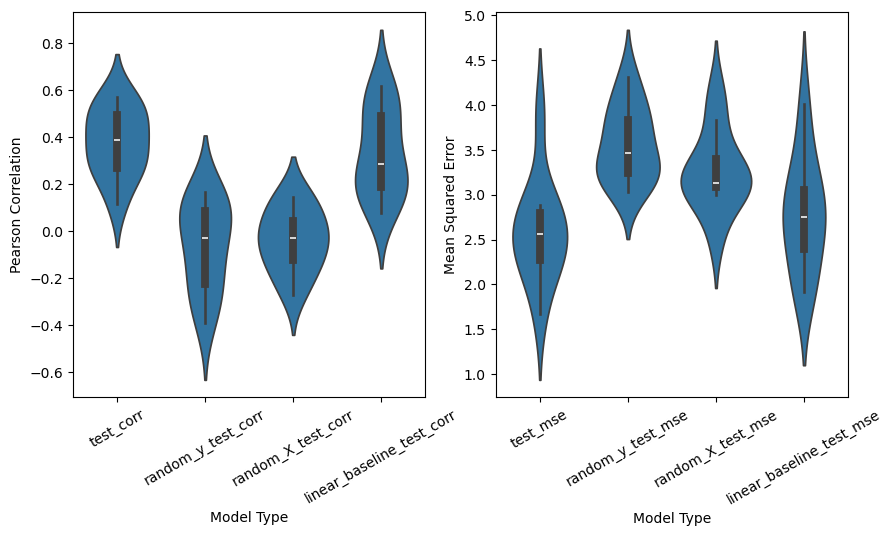

In [26]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))

for i, (metric, viz_df) in enumerate(viz_dfs.items()):
    viz_df = pd.melt(viz_df, value_name=metric, var_name = 'Model Type')
    sns.violinplot(data = viz_df, x = 'Model Type', y = metric, ax = ax[i])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), 
                     rotation = 30, ha = 'center')

In [27]:
best_res_df.test_corr.median()

np.float64(0.3864508969164058)

In [28]:
best_res_df.test_corr.mean()

np.float64(0.3771203001745195)